In [1]:
import os
import re
import requests
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse

import tiktoken
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r"^http[s]*://.+"

# Define root domain to crawl
DOMAIN = "docs.midjourney.com"
FULL_URL = "https://docs.midjourney.com/"

In [3]:
# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute,
        # add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

In [4]:
def get_hyperlinks(url):
    """Function to get the hyperlinks from a URL.

    Parameters
    ----------
    url: str
        URL to get the hyperlinks from.

    Returns
    -------
    Links: list[str]
        Hyperlinks from the URL.
    """
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:
            # If the response is not HTML, return an empty list
            if not response.info().get("Content-Type").startswith("text/html"):
                return []

            # Decode the HTML
            html = response.read().decode("utf-8")
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks


def get_domain_hyperlinks(local_domain, url):
    """Function to get the hyperlinks from a URL that are within the same domain.

    Parameters
    ----------
    local_domain: str
        Domain.

    url: str
        URL to get the hyperlinks from.

    Returns
    -------
    Links: list[str]
        Hyperlinks within the same domain as the URL.
    """
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif (
                link.startswith("#")
                or link.startswith("mailto:")
                or re.search(r"tel:", link)
            ):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    """Crawl the given domain URL to get all the hyperlinks.

    Parameters
    ----------
    url: str
        URL to get the hyperlinks from.
    """
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # While the queue is not empty, continue crawling
    while queue:
        # Get the next URL from the queue
        url = queue.pop()
        print(url)  # for debugging and to see the progress

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

    return seen

In [5]:
crawl(FULL_URL)

https://docs.midjourney.com/
https://docs.midjourney.com
https://docs.midjourney.com/docs/prompts
https://docs.midjourney.com/v1/en
https://docs.midjourney.com/multi-prompts
https://docs.midjourney.com/v1/docs/parameter-list
https://docs.midjourney.com/upscalers
https://docs.midjourney.com/docs/multi-prompts
https://docs.midjourney.com/v1/docs/image-prompts
https://docs.midjourney.com/blend
https://docs.midjourney.com/v1/docs/settings-and-presets
https://docs.midjourney.com/docs/remix
https://docs.midjourney.com/stealth
https://docs.midjourney.com/fast-relax
https://docs.midjourney.com/settings-and-presets
https://docs.midjourney.com/plans
https://docs.midjourney.com/terms-of-service
https://docs.midjourney.com/privacy-policy
https://docs.midjourney.com/v1/docs/aspect-ratios
https://docs.midjourney.com/docs/aspect-ratios
https://docs.midjourney.com/v1/docs/show-job
https://docs.midjourney.com/v1/docs/discord-emoji-reactions
https://docs.midjourney.com/show-job
https://docs.midjourney.c

In [6]:
def remove_newlines(series):
    series = series.str.replace("\n", " ", regex=True)
    series = series.str.replace("\\n", " ", regex=True)
    series = series.str.replace("  ", " ", regex=True)
    series = series.str.replace("  ", " ", regex=True)
    return series

In [7]:
# Create a list to store the text files
texts = []

# Get all the text files in the text directory
for file in os.listdir("text/" + DOMAIN + "/"):
    # Open the file and read the text
    with open("text/" + DOMAIN + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace - and _, with spaces and remove #update.
        texts.append(
            (
                file[11:-4].replace("-", " ").replace("_", " ").replace("#update", ""),
                text,
            )
        )

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns=["fname", "text"])

# Set the text column to be the raw text with the newlines removed
df["text"] = df.fname + ". " + remove_newlines(df.text)
df.to_csv("processed/scraped.csv")
df.head()

,fname,text
0,rney.com docs image size,rney.com docs image size. Midjourney Un...
1,rney.com discord emoji reactions,rney.com discord emoji reactions. Midjo...
2,rney.com stop,rney.com stop. Midjourney Stop Paramete...
3,rney.com community guidelines,rney.com community guidelines. Midjourn...
4,rney.com models,rney.com models. Midjourney Model Versi...


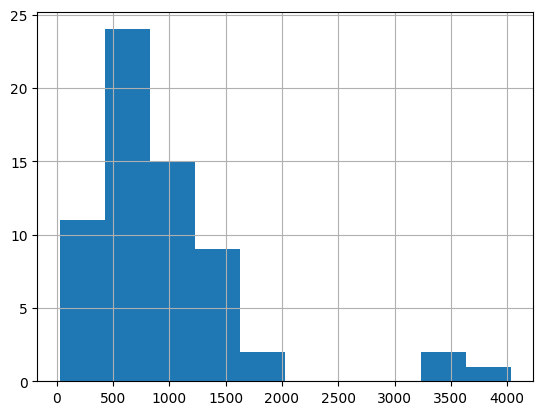

In [8]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv("processed/scraped.csv", index_col=0)
df.columns = ["title", "text"]

# Tokenize the text and save the number of tokens to a new column
df["n_tokens"] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()
plt.show()

In [9]:
max_tokens = 500


def split_into_many(text, max_tokens=max_tokens):
    """ "Function to split the text into chunks of a maximum number of tokens.

    Parameters
    ----------
    text: str
        Text to split into chunks.

    max_tokens: int
        Maximum number of tokens in a chunk.

    Returns
    -------
    chunks: list[int]
        List of tokens.
    """
    # Split the text into sentences
    sentences = text.split(". ")

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):
        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks

In [10]:
shortened = []

# Loop through the dataframe
for row in df.iterrows():
    # If the text is None, go to the next row
    if row[1]["text"] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]["n_tokens"] > max_tokens:
        shortened += split_into_many(row[1]["text"])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append(row[1]["text"])

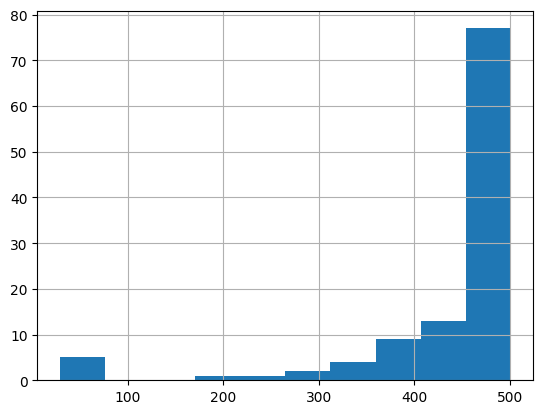

In [11]:
df = pd.DataFrame(shortened, columns=["text"])
df["n_tokens"] = df.text.apply(lambda x: len(tokenizer.encode(x)))

df.n_tokens.hist()
plt.show()

In [12]:
import dotenv

# loads .env file with your OPENAI_API_KEY
dotenv.load_dotenv()

True

In [13]:
import openai


openai.api_key = os.getenv("OPENAI_API_KEY")

df["embeddings"] = df.text.apply(
    lambda x: openai.Embedding.create(input=x, engine="text-embedding-ada-002")["data"][
        0
    ]["embedding"]
)
df.to_csv("processed/embeddings.csv")
df.head()

,text,n_tokens,embeddings
0,rney.com docs image size. Midjourney Un...,480,"[0.010620162822306156, 0.014379855245351791, 0..."
1,"DPI Dots Per Inch Dots Per Inch, Pixels Per In...",492,"[-0.008674067445099354, 0.02935047447681427, 0..."
2,rney.com discord emoji reactions. Midjo...,389,"[-0.024931350722908974, -0.023817721754312515,..."
3,rney.com stop. Midjourney Stop Paramete...,343,"[-0.016181081533432007, -0.017099468037486076,..."
4,rney.com community guidelines. Midjourn...,489,"[0.012619820423424244, -0.014879876747727394, ..."


In [14]:
import numpy as np

# from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df = pd.read_csv("processed/embeddings.csv", index_col=0)
df["embeddings"] = df["embeddings"].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,rney.com docs image size. Midjourney Un...,480,"[0.010620162822306156, 0.014379855245351791, 0..."
1,"DPI Dots Per Inch Dots Per Inch, Pixels Per In...",492,"[-0.008674067445099354, 0.02935047447681427, 0..."
2,rney.com discord emoji reactions. Midjo...,389,"[-0.024931350722908974, -0.023817721754312515,..."
3,rney.com stop. Midjourney Stop Paramete...,343,"[-0.016181081533432007, -0.017099468037486076,..."
4,rney.com community guidelines. Midjourn...,489,"[0.012619820423424244, -0.014879876747727394, ..."
